# Лабораторная работа №4
## Кластеризация

### Часть 1

Были установлены библиотеки, среди которых есть библиотека `sklearn`, с помощью которой будет выполнена кластеризация в данной лабораторной работе

In [126]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import metrics
import matplotlib.pyplot as plt

Была продублирована функция из задания, которая задаёт определенный датасет из рандомных значений

In [127]:
def make_data(n, seed):
    np.random.seed(seed)
    shift_matrix = np.array([[3, 3], [6, 9], [9, 3]])
    data = np.random.randn(3, 2, n) + shift_matrix.reshape((3, 2, 1))
    data = np.swapaxes(data, 1, 2)
    data = data.reshape((-1, 2))
    data *= np.array([[20, 0.5]])
    df = pd.DataFrame(data, columns=['x', 'y'])
    df = df.sample(frac=1.0).reset_index(drop=True)
    return df

Были созданы тренировочные и валидационные выборки из них

In [128]:
train = make_data(50, seed=31)
test = make_data(90, seed=265)

Обе выборки были стандартизированы, чтобы сохранять одинаковую размерность

In [129]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

Далее была создана функция, которая принимает на вход выборки и количество кластеров, которые необходимо создать в графике. Также данная функция выводить коэффициент силуэта, отображающий, насколько точно кластеры разделены друг от друга. Коэффициент нормализованный, поэтому может принимать значения от 0 до 1, чем ближе к 1, тем более четко кластеры разделены.

В данной функции используется кластеризация методом k-means. 

Метод k-means делит данные на k кластеров, минимизируя внутрикластерные расстояния. Он работает итеративно: сначала случайно выбираются центры кластеров, затем каждому объекту данных назначается ближайший кластер на основе расстояния до центра. После этого центры кластеров пересчитываются как среднее всех точек в кластере. Процесс повторяется, пока центры кластеров не перестанут изменяться или не будет достигнут максимум итераций

In [130]:
def clustering(train_scaled, test_scaled, n_clusters):

    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    train_labels = kmeans.fit_predict(train_scaled)

    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        plt.scatter(train_scaled[train_labels == cluster, 0], train_scaled[train_labels == cluster, 1], label=f'Кластер {cluster}')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Центр')
    plt.title(f"Кластеризация тренировочных данных с {n_clusters} кластерами")
    plt.legend()
    plt.show()

    test_labels = kmeans.predict(test_scaled)


    plt.figure(figsize=(10, 6))
    for cluster in range(n_clusters):
        plt.scatter(test_scaled[test_labels == cluster, 0], test_scaled[test_labels == cluster, 1], label=f'Кластер {cluster}')
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='X', s=200, label='Центр')
    plt.title(f"Кластеризация тестовых данных с {n_clusters} кластерами")
    plt.legend()
    plt.show()

    silhouette_avg = silhouette_score(train_scaled, train_labels)
    print(f"Коэффициент силуэта для {n_clusters} кластеров: {silhouette_avg}")

Необходимо вывести графики с 3 кластерами, также были выведены с 2 и 4 кластерами для сравнения

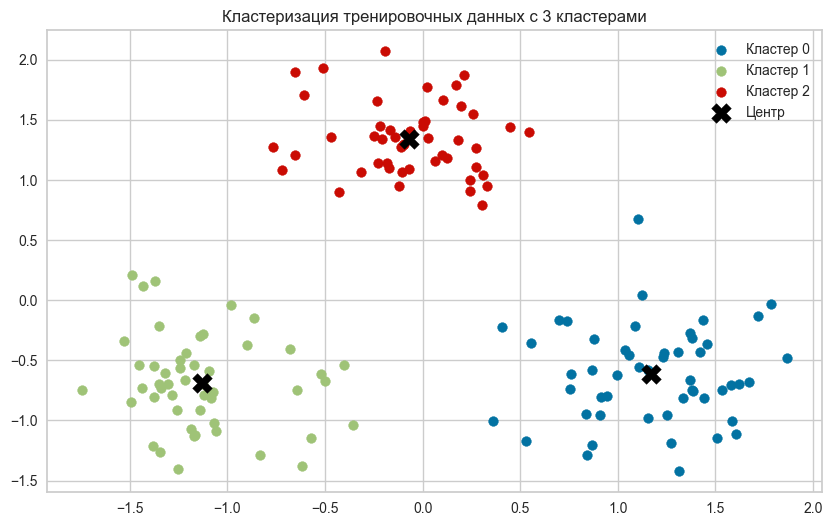

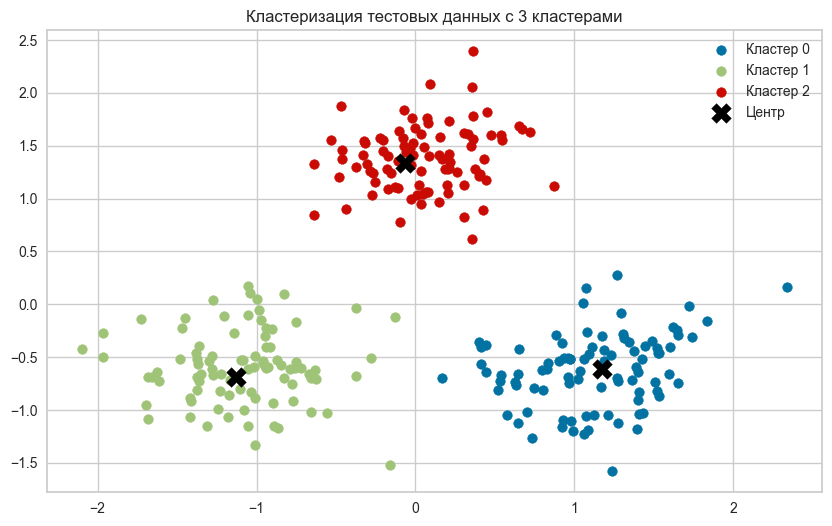

Коэффициент силуэта для 3 кластеров: 0.7133734883212319


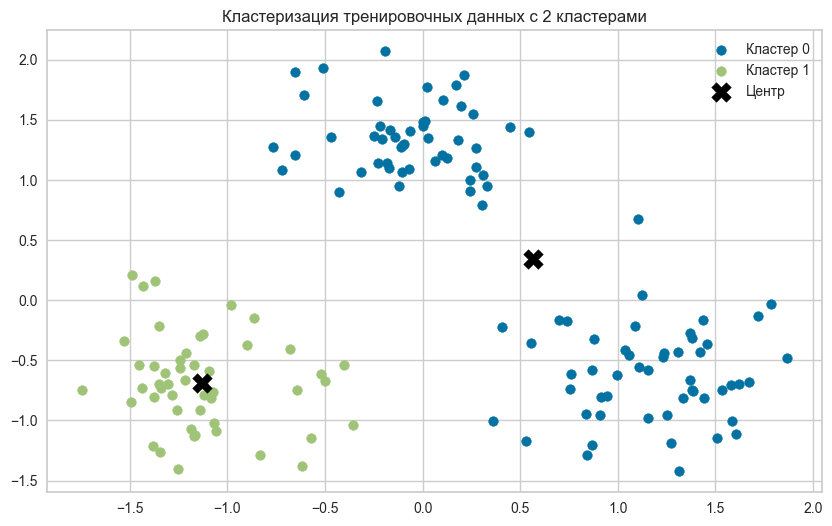

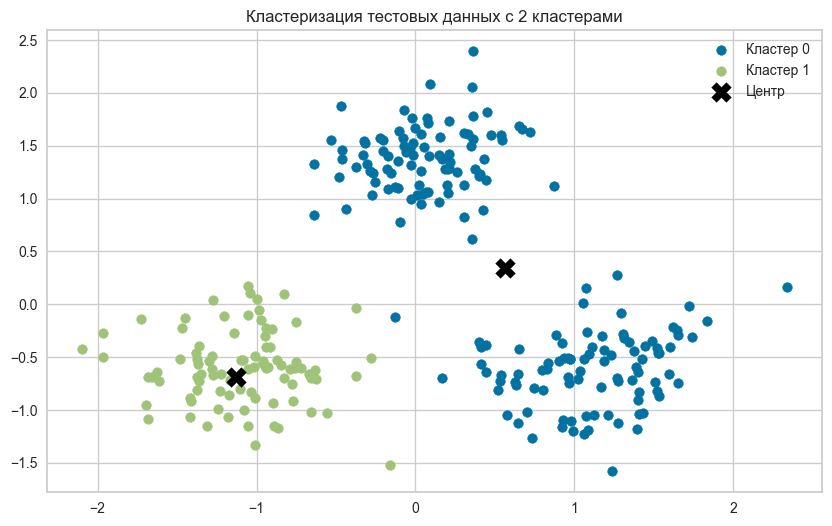

Коэффициент силуэта для 2 кластеров: 0.48142569011568714


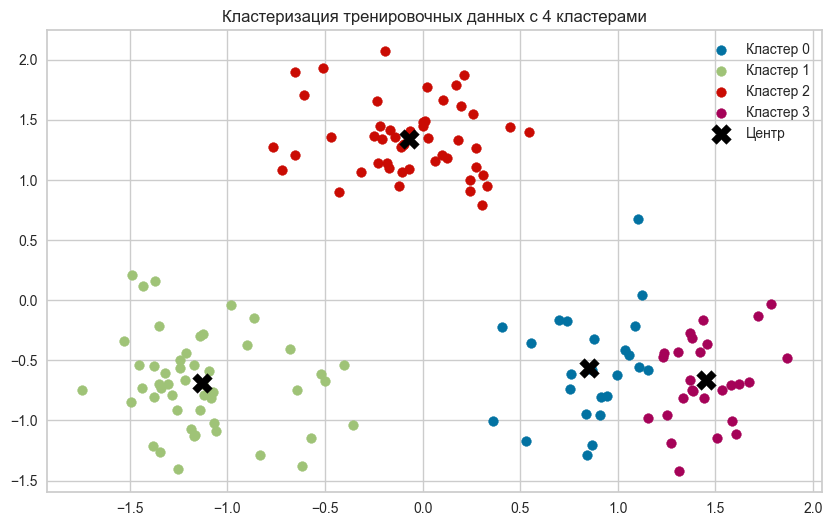

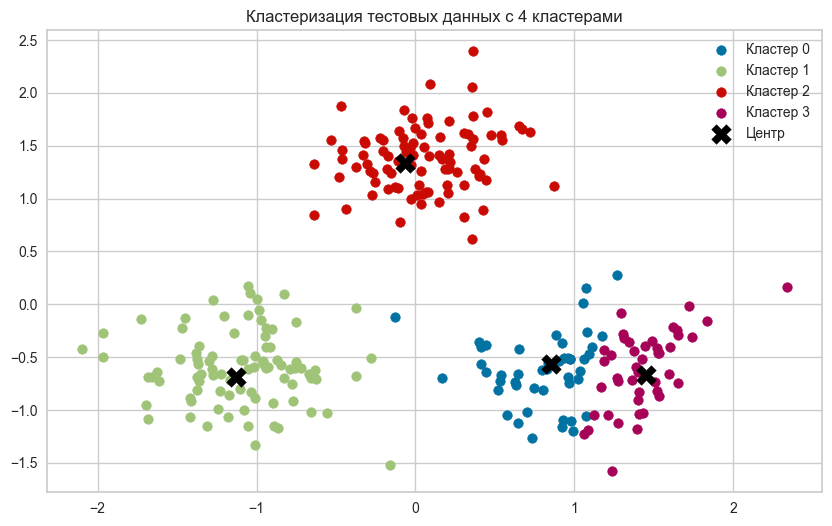

Коэффициент силуэта для 4 кластеров: 0.5751401645651767


In [ ]:
clustering(train_scaled, test_scaled, n_clusters=3)

clustering(train_scaled, test_scaled, n_clusters=2)
clustering(train_scaled, test_scaled, n_clusters=4)

+ Кластеризация с тремя кластерами:

Хорошая кластеризация с коэффициентом силуэта 0.724, что указывает на чётко разделённые кластеры.

+ Кластеризация с двумя кластерами:

Коэффициент силуэта снизился до 0.499, что говорит о менее чётком разделении данных.
+ Кластеризация с четырьмя кластерами:

Коэффициент силуэта составил 0.610, что лучше, чем для двух кластеров, но хуже, чем для трёх.

На основе данного анализа можно сказать, что не всегда чем больше кластеров, тем лучше, поэтому есть необходимость искать оптимальное количество кластеров для данного датасета - для этого применяется "метод локтя".

Метод локтя анализирует график зависимости инерции (внутрикластерной суммы квадратов расстояний) от числа кластеров. По мере увеличения числа кластеров инерция уменьшается, но после определённого момента снижение становится незначительным. Точка "перелома" на графике напоминает локоть — это и есть оптимальное число кластеров.

Для поиска оптимального количеста кластеров методом локтя используется метод `KElbowVisualizer` библиотеки `yellowbrick`. Метод принимает на вход обученную модель методом k-means, количество кластеров, которые необходимо визуализировать на графике и метрику, по которой будет составлен сам график. Был выбран коэффициент силуэта в качестве выборки

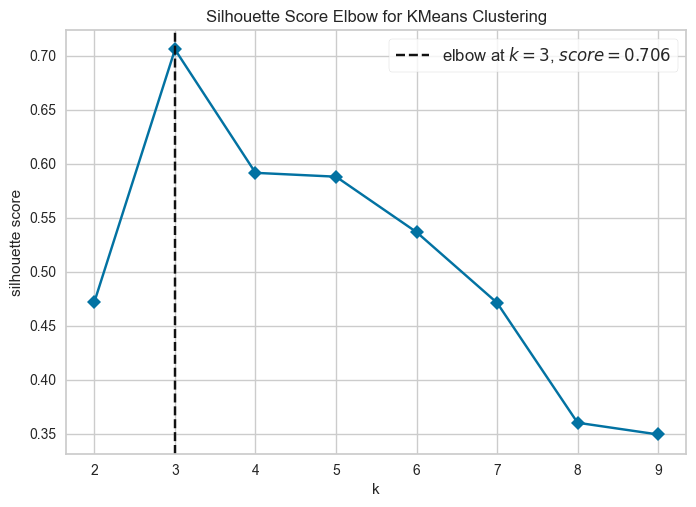

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [132]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans(random_state=42)
visualizer = KElbowVisualizer(model, k=(2, 10), metric='silhouette', timings=False)

visualizer.fit(test_scaled)
visualizer.show()

По данному графику можно определить, что оптимальное количество кластеров для данной модели является 3, так как имеет наибольший коэффициент силуэта.

### Часть 2
Вариант 1

Был загружен датасет `1heart.csv`, в котором находится информация о пациентах с анализами для определения наличия заболевания сердца. Были выведены 5 записей, чтобы оценить датасет.

In [133]:
data = pd.read_csv('1heart.csv', sep=',')

data.head(5)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140.0,289,0,Normal,172.0,N,0.0,Up,0
1,49,F,NAP,160.0,180,0,Normal,156.0,N,1.0,Flat,1
2,37,M,ATA,130.0,283,0,ST,98.0,N,0.0,Up,0
3,48,F,ASY,138.0,214,0,Normal,108.0,Y,1.5,Flat,1
4,54,M,NAP,150.0,195,0,Normal,122.0,N,0.0,Up,0


Была выведена информация о всех столбцах

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             925 non-null    int64  
 1   Sex             925 non-null    object 
 2   ChestPainType   925 non-null    object 
 3   RestingBP       923 non-null    float64
 4   Cholesterol     924 non-null    object 
 5   FastingBS       925 non-null    int64  
 6   RestingECG      924 non-null    object 
 7   MaxHR           924 non-null    float64
 8   ExerciseAngina  925 non-null    object 
 9   Oldpeak         925 non-null    float64
 10  ST_Slope        925 non-null    object 
 11  HeartDisease    925 non-null    int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 86.8+ KB


Как можно увидеть, есть записи с нулевыми значениями, а также столбец `Cholesterol` имеет тип `object`, что не соответствует числовым значениям внутри него. Также можно заметить, что столбцы `FastingBS` и `HeartDisease` имеют двоичные значения, в то время как `ExerciseAngina` также показывает значения да/нет, но написано это текстом. Ниже эти моменты будут исправлены

In [135]:
data['ExerciseAngina'] = data['ExerciseAngina'].map({'N': 0, 'Y': 1})

data['ExerciseAngina'].value_counts()

ExerciseAngina
0    553
1    372
Name: count, dtype: int64

In [136]:
nans = data[data.isnull().any(axis=1)]
display(nans)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
17,43,F,ATA,NaN,NaN,0,Normal,165.0,0,0.0,Up,0
24,40,M,NAP,NaN,215,0,Normal,138.0,0,0.0,Up,0
921,38,M,NAP,138.0,175,0,NaN,173.0,0,0.0,Up,0
923,55,F,ATA,132.0,342,0,Normal,NaN,0,1.2,Up,0


In [137]:
data = data.dropna()
data.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Было определено, что в столбце `Cholesterol` есть некорректное значение, которое было выведено и переделано в корректное, после этого столбец был преобразован в числовой

In [138]:
invalid_rows = data[pd.to_numeric(data['Cholesterol'], errors='coerce').isna()]

invalid_rows

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
922,57,F,ASY,140.0,a241,0,Normal,123.0,1,0.2,Flat,1


In [139]:
data['Cholesterol'] = data['Cholesterol'].replace('a241','241')
data['Cholesterol'] = pd.to_numeric(data['Cholesterol'])

Был выведен метод `.describe()` для всех числовых столбцов

In [140]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,53.492942,132.436482,198.771987,0.232356,136.908795,0.403909,0.884691,0.552660
std,9.442976,18.483851,109.224092,0.422564,25.504184,0.490946,1.065871,0.497489
min,28.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,174.000000,0.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.000000,0.500000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


Отсюда видно, что столбцы `RestingBP` и `Cholesterol` имеют записи со значением 0, что в данном контексте является некорректным. Поэтому все нули были заменены на средние значения

In [141]:
data['RestingBP'] = data['RestingBP'].replace(0, data['RestingBP'].median())
data['Cholesterol'] = data['Cholesterol'].replace(0, data['Cholesterol'].median())

data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000
mean,53.492942,132.577633,240.418024,0.232356,136.908795,0.403909,0.884691,0.552660
std,9.442976,17.960364,54.006099,0.422564,25.504184,0.490946,1.065871,0.497489
min,28.000000,80.000000,85.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.000000,0.500000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


Предобработка завершена, можно анализировать данный датасет.

Была выделена целевая переменная `HeartDisease`, по которой была выведена матрица диаграмм

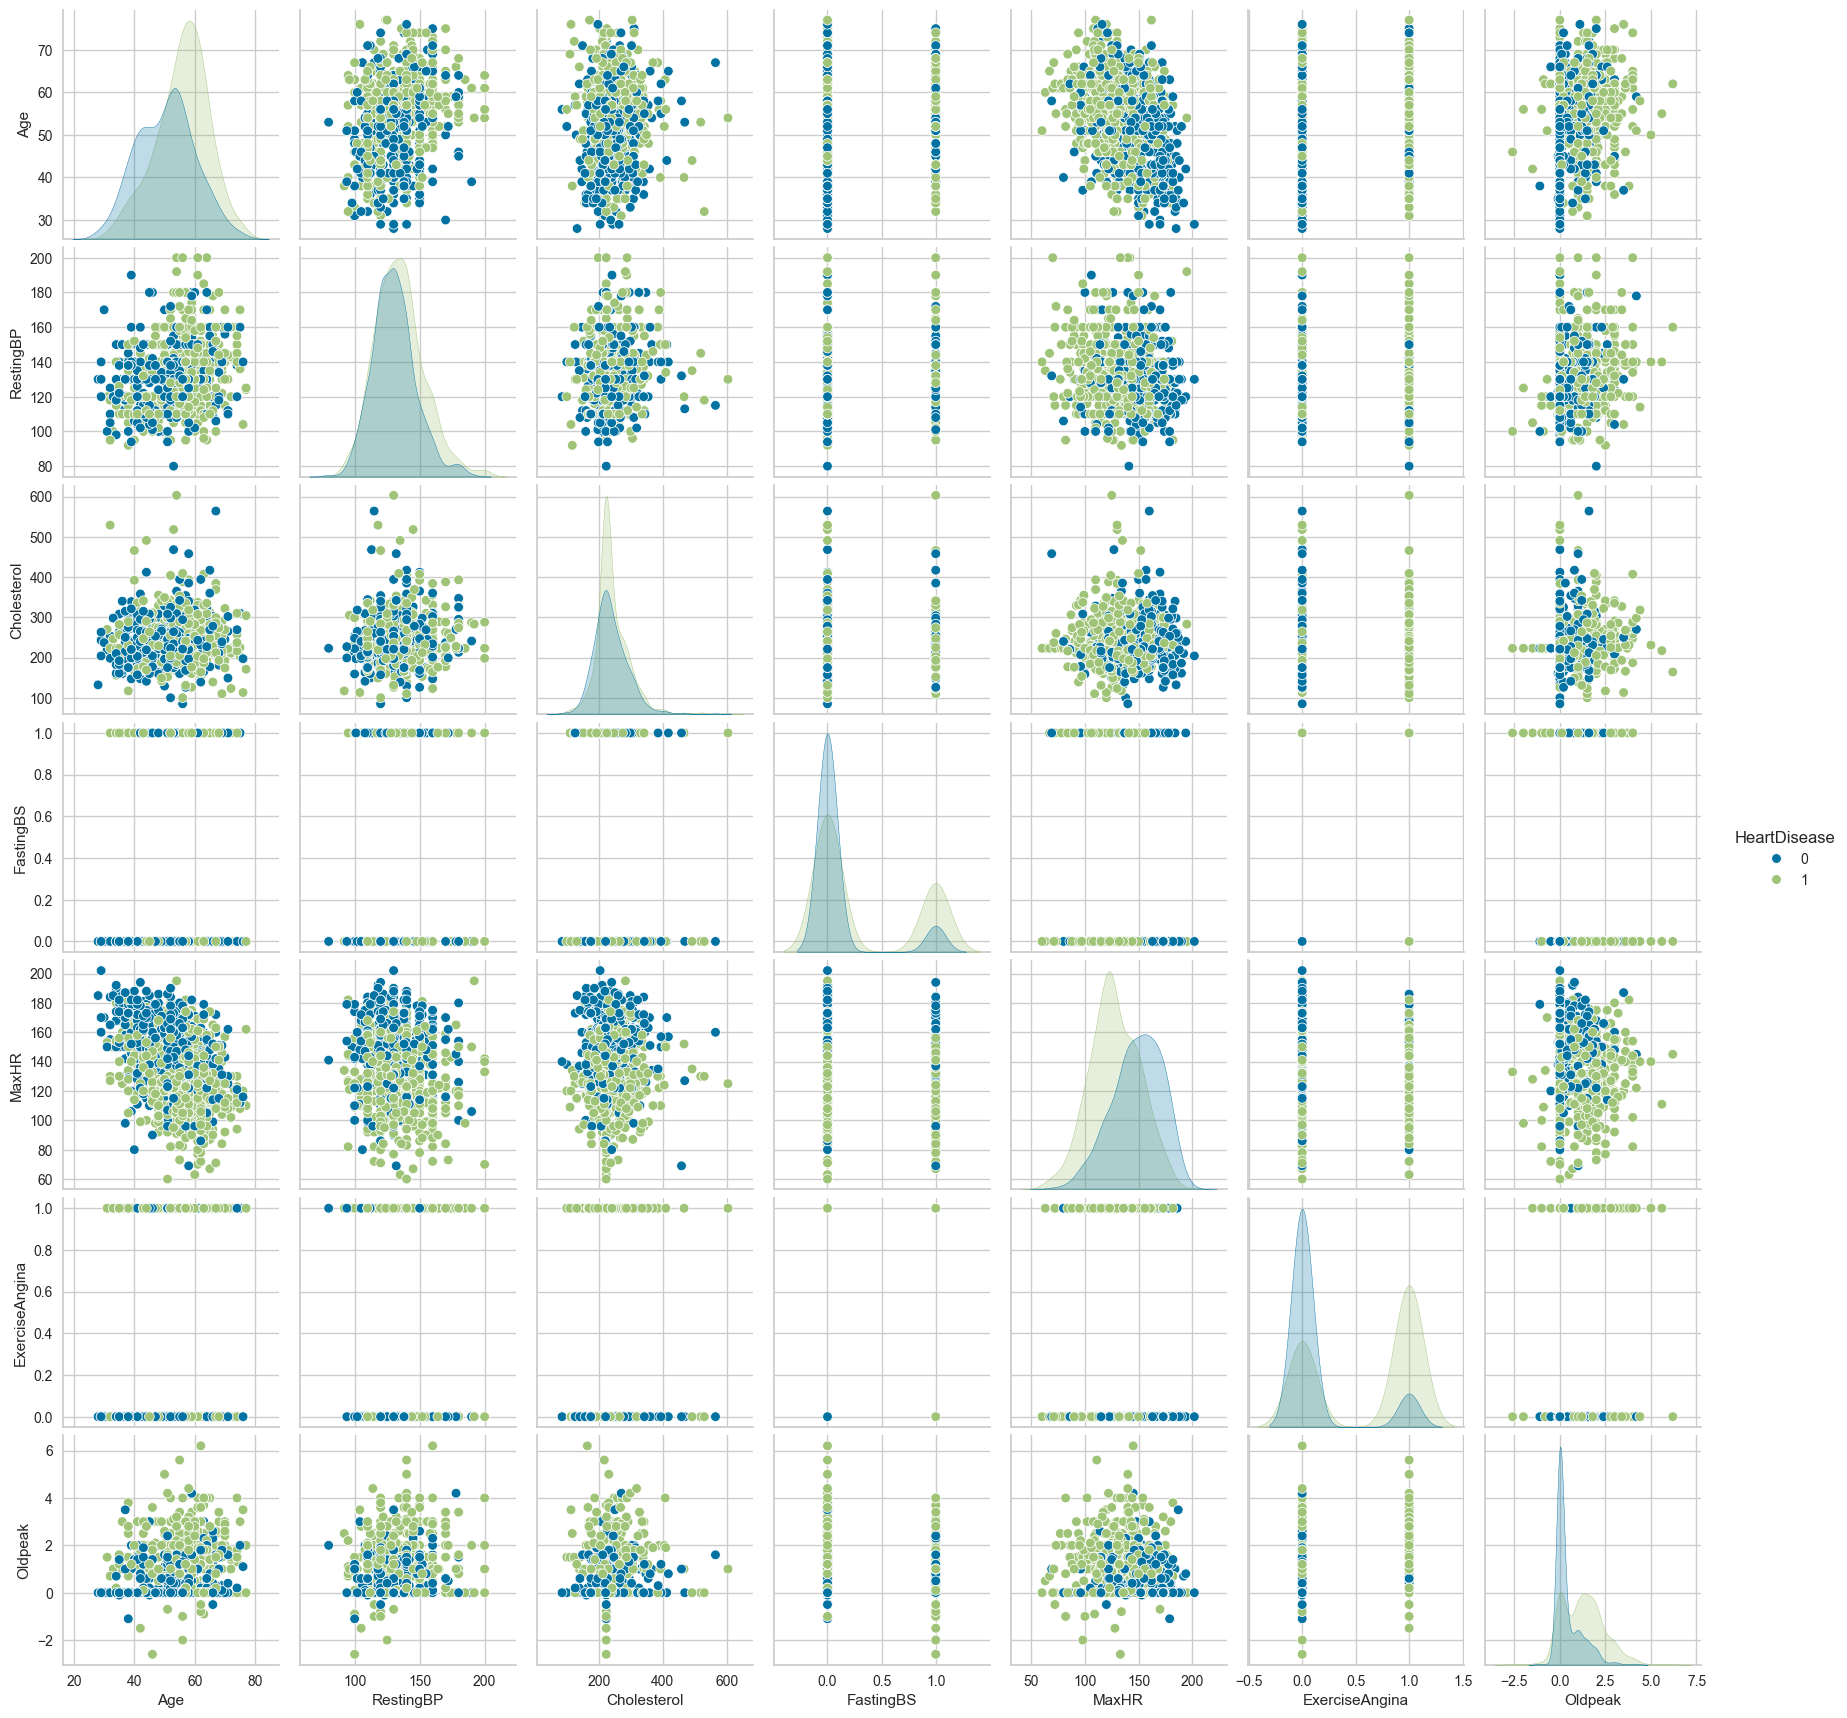

In [142]:
import seaborn as sns

sns.pairplot(data, hue= 'HeartDisease')

По данной матрице диаграмм видно, что данные имеют высокую степень перекрытия между группами, что затрудняет чёткое разделение классов. Наиболее отличающиеся признаки — это `Oldpeak`, `ExerciseAngina`, и `MaxHR`. Для пациентов с больным сердцем значения `Oldpeak` и `ExerciseAngina` смещены вверх, а `MaxHR` наоборот вниз. 

Был создан датасет только из числовых столбцов, чтобы можно было рассчитывать количество кластеров. Также все значения были нормализованы

In [143]:
num_data = data.select_dtypes(exclude=['object'])
scaler = StandardScaler()
scaled = scaler.fit_transform(num_data)

Для определения оптимального количества кластеров был выведен метод локтя по метрике коэффициента силуэта

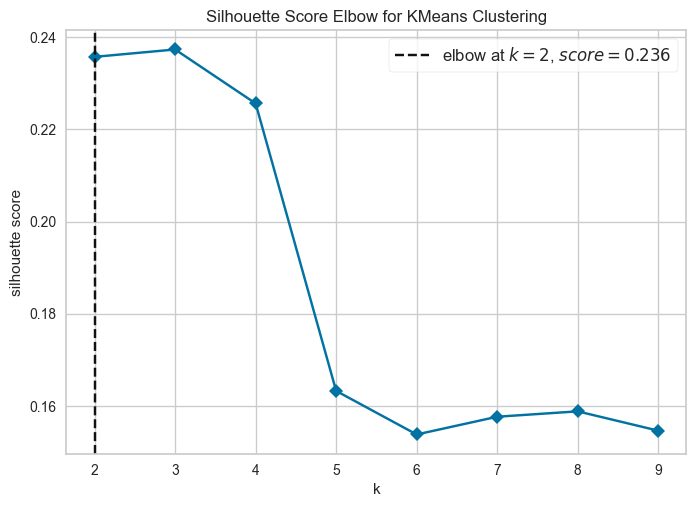

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [144]:
kmeans_elbow = KMeans(random_state= 42)
visualizer = KElbowVisualizer(kmeans_elbow, k=(2, 10), metric='silhouette', timings=False)

visualizer.fit(scaled)
visualizer.show()

Данный график показывает, что лучше всего использовать два кластера для дальнейшей работы, которые были выведены на графике с центрами этих кластеров.

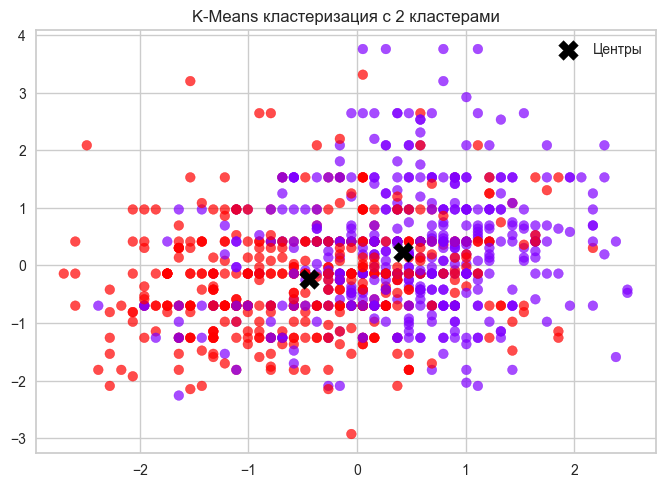

In [153]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(scaled)

labels = kmeans.labels_

plt.scatter(scaled[:, 0], scaled[:, 1], c=labels, cmap='rainbow', alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, marker= "X", c='black', label='Центры')
plt.title("K-Means кластеризация с 2 кластерами")
plt.legend()
plt.show()

По данному графику видно, что точки двух кластеров частично перекрываются, особенно в центральной части графика, что указывает на слабую отделимость кластеров. Чёрные крестики обозначают центры кластеров, вокруг которых данные распределены с некоторой плотностью.

Также был выведен график силуэтного анализа с помощью метода `SilhouetteVisualizer` библиотеки `yellowbrick`

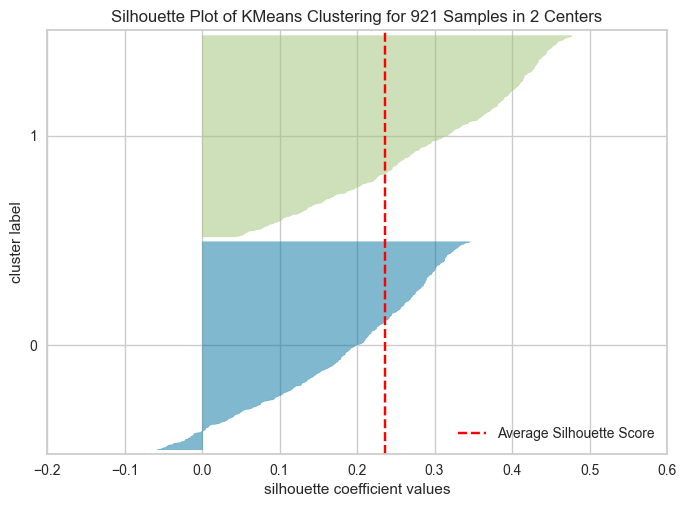

In [146]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(scaled)
visualizer.show()
plt.show()

График силуэтного анализа показывает, что средний коэффициент силуэта около 0.236, указывая на слабую отделимость кластеров. Наличие отрицательных значений силуэта в синем кластере свидетельствует о том, что некоторые точки ближе к другому кластеру, чем к своему. Это подтверждает пересечение кластеров и сложность в их чётком разделении.

Далее были выведены средние значения по каждому кластеру

In [ ]:
num_data['Cluster'] = labels

cluster_means = num_data.groupby('Cluster').mean()

display(cluster_means)

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease
Cluster,,,,,,,,
0,57.506410,136.630342,243.324786,0.346154,123.000000,0.735043,1.430556,0.920940
1,49.346578,128.390728,237.415011,0.114790,151.278146,0.061810,0.320751,0.172185


Под данной таблице можно сказать, что кластеры поделились примерно по целевой переменной `HeartDisease`. Первый кластер показывает средние значения пациентов, которые в большинстве своём были признаны как люди с больным сердцем, второй кластер отвечает за здоровых людей. Однако в этих распределениях могут находиться здоровые люди среди больных, так и наоборот, но процент таких "выбросов" довольно низок для данного датасета. Также по данной таблице можно сказать, что у больных людей все значения выше, чем у здоровых, кроме максимальной частоты сердцебиения, что выглядит довольно правдоподобно для данного контекста.


Были просчитаны метрики для получившихся кластеров

In [148]:
silhouette_avg = silhouette_score(scaled, labels)
inertia = kmeans.inertia_ 

print(silhouette_avg, inertia)

0.23575595058984847 5587.144322703134


In [149]:
true = data['HeartDisease']

pred = labels

In [150]:
ari = metrics.adjusted_rand_score(true, pred)
hs = metrics.homogeneity_score(true, pred)
cs = metrics.completeness_score(true, pred)
vms = metrics.v_measure_score(true, pred)

print(ari,hs,cs,vms)

0.5624357394687796 0.4671077944419053 0.4634519950054922 0.4652727136324508



Значение метрики ARI 0,56 указывает на то, что кластеры не идеально соответствуют истинным группам, но всё же есть некоторая согласованность.
Метрики гомогенности и полноты указывают на то, что в кластерах находятся объекты, которые принадлежат одному кластеру, но не полностью соответствуют одной истинной группе. Это стало ясно по прошлой таблице, так как в обоих кластерах находятся элементы, которые должны относиться к другому кластеру. Метрика V-measure является средним между гомогенностью и полнотой, поэтому у него такое же среднее значение

Далее была сделана дендрограмма по тем же значениям. Дендрограмма — это визуальное представление результатов иерархической кластеризации. Она показывает, как данные объединяются в кластеры на разных уровнях иерархии. Дендрограмма была выполнена с помощью библиотек `scipy` и `sklearn`

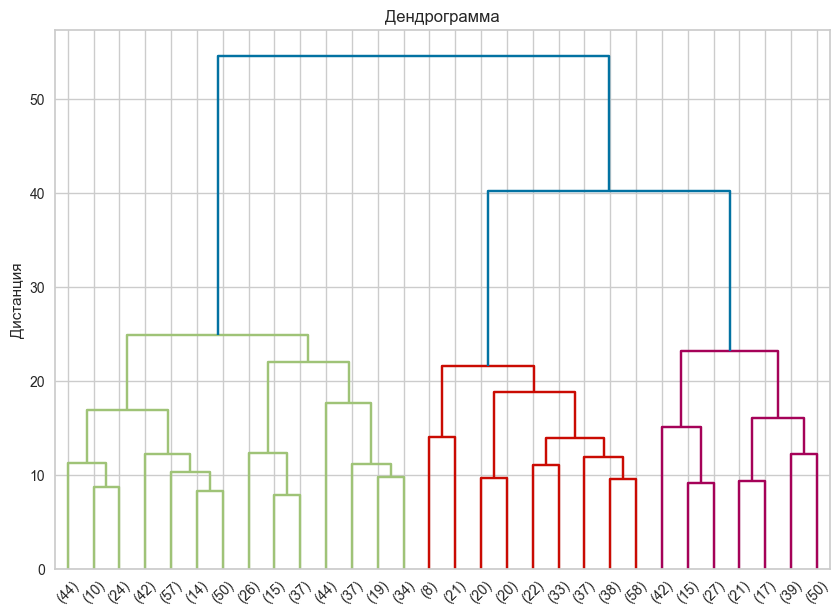

0.20697288105301964


In [154]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

linked = linkage(scaled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, truncate_mode='lastp', p=30, show_leaf_counts=True)
plt.title('Дендрограмма')
plt.ylabel('Дистанция')
plt.show()

agg_clustering = AgglomerativeClustering(n_clusters=2, linkage='ward')
agg_labels = agg_clustering.fit_predict(scaled)

num_data['Agg_Cluster'] = agg_labels

agg_cluster_means = num_data.groupby('Agg_Cluster').mean()

agg_silhouette_avg = silhouette_score(scaled, agg_labels)
print(agg_silhouette_avg)

Дендрограмма показывает структуру иерархической кластеризации. Длинная горизонтальная линия на уровне расстояния около 50 указывает на разделение данных на два основных кластера. Если спуститься ниже, на уровень около 30, можно выделить три кластера. Зеленый кластер (слева) демонстрирует высокую однородность, так как его объекты объединяются на малых расстояниях, в то время как красный и фиолетовый кластеры (справа) имеют большее разнообразие. Это указывает на возможность дальнейшего деления данных.

По результатам работы можно заключить, что оба метода кластеризации, K-Means и иерархическая кластеризация, справились с задачей, но качество разделения данных оказалось слабым из-за сложности структуры данных и перекрытия кластеров. K-Means показал более высокое значение силуэтного коэффициента (0.236) по сравнению с иерархической кластеризацией (0.207), что указывает на его лучшее качество разделения в данной задаче. Однако иерархическая кластеризация предоставила больше информации о структуре данных за счёт дендрограммы, что позволяет визуально анализировать иерархию кластеров.

### Вывод


В ходе работы были выполнены два больших этапа: кластеризация сгенерированных данных, а также кластеризация реального медицинского датасета `1heart.csv`.

На первом этапе была реализована функция для генерации набора данных с заданным количеством объектов в группах и фиксируемым зерном случайных значений. Созданные данные были разделены на тренировочные и тестовые выборки, после чего выполнена их стандартизация. Метод K-Means был применён для кластеризации тренировочных данных на три кластера. Метки кластеров и центры визуализированы, а для тестовых данных была выполнена дополнительная кластеризация с последующей визуализацией. Коэффициент силуэта, рассчитанный для `n_clusters` = 3, 2 и 4, показал, что лучшее качество кластеризации достигается при трёх кластерах. Метод локтя подтвердил это, демонстрируя минимальную инерцию при разумном числе кластеров.

На втором этапе проводилась кластеризация медицинских данных. Они были очищены от пропусков, некорректных значений и выбросов, а числовые признаки масштабированы. Метод K-Means показал силуэтный коэффициент 0.236, а иерархическая кластеризация — 0.207, что указывает на слабую отделимость кластеров в обоих случаях. Дендрограмма позволила проанализировать структуру данных, показывая возможность разбиения на два или три кластера. Метрики, сравнивающие истинные метки кластеров (`HeartDisease`) с предсказанными, указали на умеренное соответствие (Adjusted Rand Index — 0.56)